In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [5]:
df = pd.read_csv('/content/drive/MyDrive/pmi-data.csv')

df = df.drop(['id'], axis=1)
df = df.drop('Unnamed: 0', axis=1)
X = df.drop(['stroke'], axis=1)
y = df['stroke']

"""
Splitting the data helps in evaluating the model's ability to generalize to new, unseen data, preventing overfitting
by ensuring the model is not tested on the same data it was trained on.

Shuffling the data before splitting is essential for avoiding bias caused by the dataset's initial order and ensuring
that both the training and validation sets are representative with a uniform distribution of data.
"""

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [6]:
print(df.describe())

            gender          age  hypertension  heart_disease  ever_married  \
count  3566.000000  3566.000000   3566.000000    3566.000000   3566.000000   
mean      1.394279    48.853898      0.125070       0.063937      0.759955   
std       0.489337    18.874375      0.330845       0.244675      0.427170   
min       0.000000    10.000000      0.000000       0.000000      0.000000   
25%       1.000000    34.000000      0.000000       0.000000      1.000000   
50%       1.000000    50.000000      0.000000       0.000000      1.000000   
75%       2.000000    63.000000      0.000000       0.000000      1.000000   
max       2.000000    82.000000      1.000000       1.000000      1.000000   

         work_type  Residence_type  avg_glucose_level          bmi  \
count  3566.000000     3566.000000        3566.000000  3566.000000   
mean      3.424846        0.491307         108.982011    30.243326   
std       0.894640        0.499995          48.292204     7.155000   
min       0.00000

In [7]:
class HealthcareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx].values, dtype=torch.float), torch.tensor(self.labels.iloc[idx], dtype=torch.float)

train_dataset = HealthcareDataset(X_train, y_train)
val_dataset = HealthcareDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
    )

In [16]:
class StrokeModel(nn.Module):
    def __init__(self, input_size):
        super(StrokeModel, self).__init__()
        self.l1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.l2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.l3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.bn1(self.l1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.l2(x)))
        x = self.dropout(x)
        x = self.l3(x)
        return x

input_size = X_train.shape[1]
model = StrokeModel(input_size)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

Epoch 1, Train Loss: 0.7314, Validation Loss: 0.7351, Train Acc: 0.3874, Val Acc: 0.3151
Epoch 2, Train Loss: 0.6827, Validation Loss: 0.6980, Train Acc: 0.5021, Val Acc: 0.4160
Epoch 3, Train Loss: 0.6537, Validation Loss: 0.6667, Train Acc: 0.5926, Val Acc: 0.5560
Epoch 4, Train Loss: 0.6213, Validation Loss: 0.6367, Train Acc: 0.7069, Val Acc: 0.6919
Epoch 5, Train Loss: 0.5907, Validation Loss: 0.6044, Train Acc: 0.7679, Val Acc: 0.7535
Epoch 6, Train Loss: 0.5636, Validation Loss: 0.5831, Train Acc: 0.8219, Val Acc: 0.7997
Epoch 7, Train Loss: 0.5375, Validation Loss: 0.5534, Train Acc: 0.8668, Val Acc: 0.8585
Epoch 8, Train Loss: 0.5155, Validation Loss: 0.5352, Train Acc: 0.8903, Val Acc: 0.8810
Epoch 9, Train Loss: 0.4935, Validation Loss: 0.5087, Train Acc: 0.9036, Val Acc: 0.9090
Epoch 10, Train Loss: 0.4727, Validation Loss: 0.4925, Train Acc: 0.9229, Val Acc: 0.9314
Epoch 11, Train Loss: 0.4527, Validation Loss: 0.4666, Train Acc: 0.9299, Val Acc: 0.9300
Epoch 12, Train Los

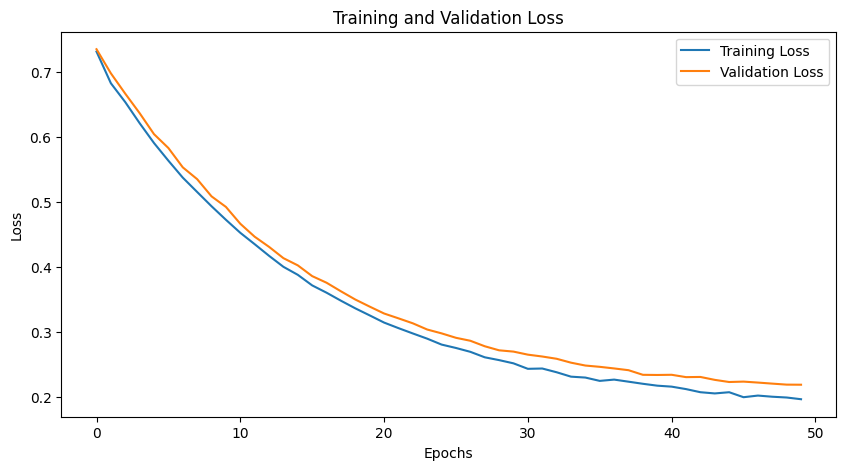

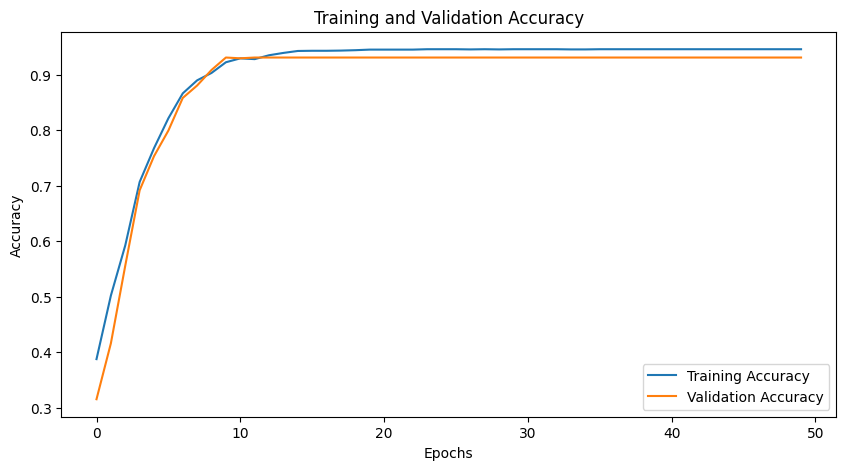

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs = 50

train_losses, val_losses = [], []
train_acc, val_acc = [], []


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    train_correct, train_total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        train_total += labels.size(0)
        train_correct += (predicted.flatten() == labels).sum().item()

    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    y_pred, y_true = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels.unsqueeze(1))
            val_running_loss += val_loss.item()
            predicted = torch.sigmoid(outputs).round()
            val_total += labels.size(0)
            val_correct += (predicted.flatten() == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))
    train_acc.append(train_correct / train_total)
    val_acc.append(val_correct / val_total)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')


plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

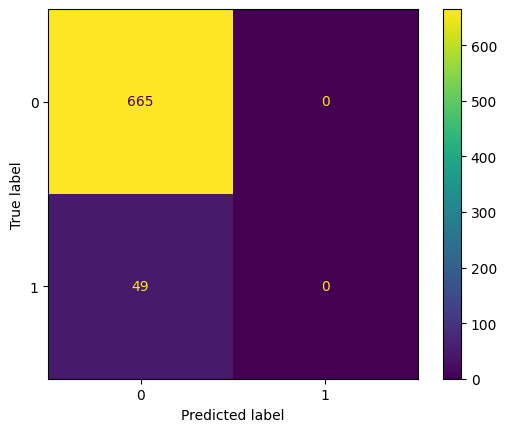

In [11]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay
import seaborn as sns

y_pred, y_true = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs).round()
        y_pred.extend(predicted.flatten().tolist())
        y_true.extend(labels.tolist())

conf_matrix = confusion_matrix(y_true, y_pred)
display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
display_matrix.plot()

In [18]:
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

Epoch 1, Train Loss: 1.2089, Validation Loss: 1.2709, Train Acc: 0.4358, Val Acc: 0.4804, Precision : 0.1054, Recall : 0.8776, Val F1: 0.1882
Epoch 2, Train Loss: 1.2015, Validation Loss: 1.2360, Train Acc: 0.4793, Val Acc: 0.5182, Precision : 0.1169, Recall : 0.9184, Val F1: 0.2074
Epoch 3, Train Loss: 1.1518, Validation Loss: 1.2170, Train Acc: 0.4958, Val Acc: 0.5280, Precision : 0.1190, Recall : 0.9184, Val F1: 0.2108
Epoch 4, Train Loss: 1.1349, Validation Loss: 1.2033, Train Acc: 0.5126, Val Acc: 0.5266, Precision : 0.1187, Recall : 0.9184, Val F1: 0.2103
Epoch 5, Train Loss: 1.1219, Validation Loss: 1.1876, Train Acc: 0.5330, Val Acc: 0.5434, Precision : 0.1185, Recall : 0.8776, Val F1: 0.2087
Epoch 6, Train Loss: 1.1137, Validation Loss: 1.1822, Train Acc: 0.5347, Val Acc: 0.5350, Precision : 0.1165, Recall : 0.8776, Val F1: 0.2057
Epoch 7, Train Loss: 1.0918, Validation Loss: 1.1716, Train Acc: 0.5340, Val Acc: 0.5434, Precision : 0.1185, Recall : 0.8776, Val F1: 0.2087
Epoch 

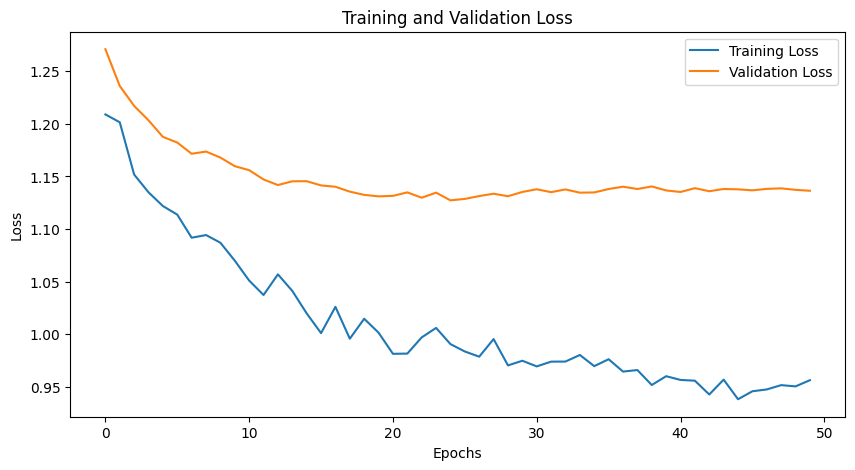

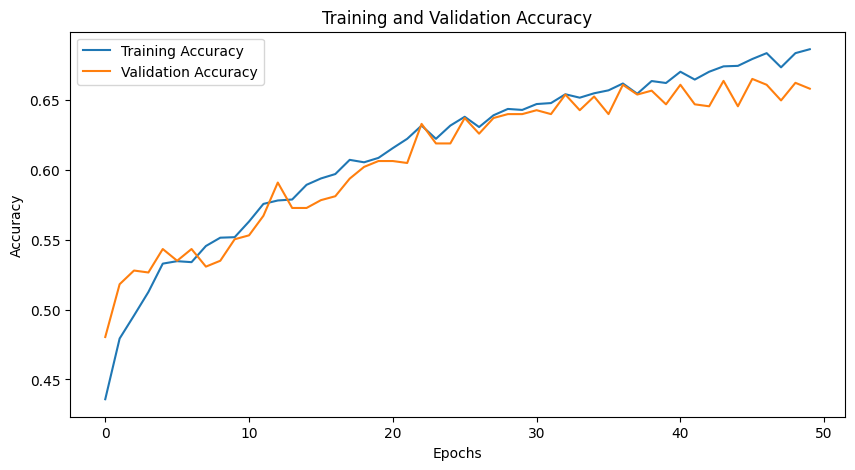

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs = 50

train_losses, val_losses = [], []
train_acc, val_acc = [], []


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    train_correct, train_total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        train_total += labels.size(0)
        train_correct += (predicted.flatten() == labels).sum().item()

    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    y_pred, y_true = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels.unsqueeze(1))
            val_running_loss += val_loss.item()
            predicted = torch.sigmoid(outputs).round()
            val_total += labels.size(0)
            val_correct += (predicted.flatten() == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))
    train_acc.append(train_correct / train_total)
    val_acc.append(val_correct / val_total)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, Precision : {precision:.4f}, Recall : {recall:.4f}, Val F1: {f1_score:.4f}')


plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


REGRESSION

In classification, the goal is to assign each data point to a specific category, using loss functions like Cross-Entropy Loss for discrete outcomes. In regression, the aim is to predict a continuous value, employing Mean Squared Error (MSE) or Mean Absolute Error (MAE) for numerical targets. For example, predicting BMI, is a regression task due to its continuous nature. The main differences are the type of target data (categorical vs. numerical) and the loss functions used.

To adapt the code for BMI prediction, I switched the loss function to Mean Squared Error (MSE), suitable for the regression nature of the task. The model evaluation now relies on the R-squared metric, which better reflects performance in regression scenarios. In terms of data preparation, the "BMI" column was separated as the target variable to be predicted, aligning with the regression objective.

Epoch 1, Train Loss: 945.1270, Validation Loss: 984.5937, R-squared: -17.9893
Epoch 2, Train Loss: 901.4595, Validation Loss: 937.1669, R-squared: -17.0600
Epoch 3, Train Loss: 856.3335, Validation Loss: 891.8005, R-squared: -16.1720
Epoch 4, Train Loss: 802.3190, Validation Loss: 832.2962, R-squared: -15.0068
Epoch 5, Train Loss: 737.3688, Validation Loss: 764.7227, R-squared: -13.6900
Epoch 6, Train Loss: 664.0755, Validation Loss: 683.3580, R-squared: -12.1132
Epoch 7, Train Loss: 582.3022, Validation Loss: 597.3168, R-squared: -10.4515
Epoch 8, Train Loss: 498.9686, Validation Loss: 503.4646, R-squared: -8.6210
Epoch 9, Train Loss: 414.0130, Validation Loss: 412.1173, R-squared: -6.8443
Epoch 10, Train Loss: 333.1273, Validation Loss: 325.6528, R-squared: -5.1643
Epoch 11, Train Loss: 261.8756, Validation Loss: 259.4445, R-squared: -3.8935
Epoch 12, Train Loss: 199.4503, Validation Loss: 205.1485, R-squared: -2.8235
Epoch 13, Train Loss: 153.3309, Validation Loss: 147.4628, R-squar

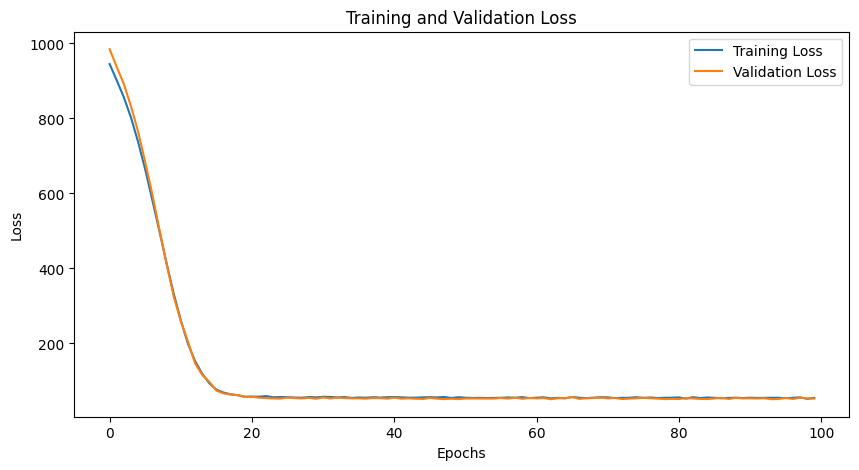

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv('/content/drive/MyDrive/pmi-data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop(['id'], axis=1)
X = df.drop(['bmi'], axis=1)
y = df['bmi']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

class HealthcareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx].values, dtype=torch.float), torch.tensor(self.labels.iloc[idx], dtype=torch.float)

train_dataset = HealthcareDataset(X_train, y_train)
val_dataset = HealthcareDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
    )

class BMIModel(nn.Module):
    def __init__(self, input_size):
        super(BMIModel, self).__init__()
        self.l1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.l2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.l3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.bn1(self.l1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.l2(x)))
        x = self.dropout(x)
        x = self.l3(x)
        return x

input_size = X_train.shape[1]
model = BMIModel(input_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs = 100

train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_running_loss = 0.0
    y_pred, y_true = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels.unsqueeze(1))
            val_running_loss += val_loss.item()
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    val_loss = val_running_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    r_squared = r2_score(y_true, y_pred)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, R-squared: {r_squared:.4f}')



plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()